In [1]:
import glob
import pandas as pd
import numpy as np
import MAG as nxmag
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import h3_util
from haversine import haversine, Unit

In [2]:
base_date_start = '2022-07-11'
base_date_end = '2022-07-15'

In [3]:
dir = f"{base_date_start}_to_{base_date_end}"

<h3>Data Loading</h3>

In [4]:
mag_t = pd.read_parquet(f"{dir}//mag_t.parquet")
mag_vt = pd.read_parquet(f"{dir}//mag_vt.parquet")
bairro_map = h3_util.load_bairro_data('bairros.csv')
neighborhood = pd.DataFrame(
    {
        'h3_index': list(bairro_map.keys()),
        'neighborhood': list(bairro_map.values())
    }
)
neighborhood[['latitude', 'longitude']] = neighborhood['h3_index'].apply(lambda h3_index: pd.Series(h3_util.h3_to_lat_lng(h3_index)))
neighborhood_centroids = neighborhood.groupby('neighborhood')[['latitude', 'longitude']].mean().reset_index()
dim_bs = pd.read_parquet(f"{dir}//dim_bs.parquet")
dim_bs['dummy_id'] = dim_bs.dummy_id.astype(int)

<h3>Start Location Selection</h3>

In [6]:
bsclusters = []
for idx1, row1 in dim_bs.query(f"type_norm == 'Terminal'").iterrows():
    cluster = {
        "centroid_dummy_id": row1['dummy_id'],
        "centroid_name": row1['name_norm'],
        "centroid_neighborhood": row1['neighborhood']
    }
    dummy_ids = []
    dummy_ids.append(row1['dummy_id'])
    for idx2, row2 in dim_bs.query(f"type_norm != 'Terminal'").iterrows():
        if haversine((row1['latitude'], row1['longitude']), (row2['latitude'], row2['longitude']), Unit.METERS) <= 1000:
            dummy_ids.append(row2['dummy_id'])
    cluster.update({"dummy_ids": dummy_ids})
    bsclusters.append(cluster)

<h3>Functions Definitions</h3>

In [7]:
def sort_by_time(neighbors):
    return sorted(
        neighbors, key = lambda neighbor: neighbor[4]
    )

def calculate_neighborhood_pct_grouped(df, total_neighborhoods, grouping_columns):
    """
    Sorts the DataFrame by 'ts' and calculates the cumulative 'pct' for each group of reached neighborhoods.

    Args:
        df (pd.DataFrame): DataFrame with columns 'neighborhood', 'ts', and grouping columns.
        total_neighborhoods (int): Total number of neighborhoods in the area considered.
        grouping_columns (list): List of columns to group the data by.

    Returns:
        pd.DataFrame: DataFrame with updated 'pct' representing the cumulative percentage of neighborhoods reached for each group.
    """

    # Sort the DataFrame by 'ts' within each group
    df = df.sort_values('ts', ascending=True)

    # Group by specified columns and calculate pct for each group
    def calculate_pct(group):
        # Count the unique neighborhoods within each group
        unique_bairros = group['neighborhood'].unique()
        bairro_mapping = {bairro: i + 1 for i, bairro in enumerate(unique_bairros)}
        group['reached_neighborhood'] = group['neighborhood'].map(bairro_mapping)
        group['pct'] = (group['reached_neighborhood'] / total_neighborhoods)
        return group

    df = df.groupby(grouping_columns, group_keys = False).apply(calculate_pct)
    
    return df

<h3>Running Simulations</h3>

In [26]:
start_simulation_time = 420
end_simulation_time = 720
time_step = 15

neighborhood_time = []
for start_time in range(start_simulation_time, 480, 60):

    for end_time in range(start_time + time_step, end_simulation_time + time_step, time_step):

        print(f"\nStarting simulation for interval {start_time}-{end_time}...")
    
        # Mag Creation
        
        G_t = nxmag.MultiAspectDiGraph(name = 'Sem clusters')
        for idx, row in mag_t.query(f"tm_u >= {start_time} and tm_v <= {end_time}").iterrows():
            u = (row['dummy_id_u'], row['line_code_u'], row['vehicle_u'], row['neighborhood_u'], row['ts_u'], row['tm_u'], row['th_u'])
            v = (row['dummy_id_v'], row['line_code_v'], row['vehicle_v'], row['neighborhood_v'], row['ts_v'], row['tm_v'], row['th_v'])
            w = row['dts']
            G_t.add_edge(u, v, weight = w)   
        
        G_vt = nxmag.MultiAspectDiGraph(name = 'Com clusters')
        for idx, row in mag_vt.query(f"tm_u >= {start_time} and tm_v <= {end_time}").iterrows():
            u = (row['dummy_id_u'], row['line_code_u'], row['vehicle_u'], row['neighborhood_u'], row['ts_u'], row['tm_u'], row['th_u'])
            v = (row['dummy_id_v'], row['line_code_v'], row['vehicle_v'], row['neighborhood_v'], row['ts_v'], row['tm_v'], row['th_v'])
            w = row['dts']
            G_vt.add_edge(u, v, weight = w)   
        
        # Run Simulations
        
        aspect = 'dummy_id'
        Gs = [G_t, G_vt]        
        
        for cluster in bsclusters:
        
            #print(f"\nStarting processing for cluster = {cluster['centroid_name']}...")
        
            dummy_ids = cluster['dummy_ids']
                
            starting_nodes = mag_t.query(f"tm_u >= {start_time} and tm_u <= {start_time} + 5 and tm_v <= {end_time} and {aspect}_u == @dummy_ids")[[
                'dummy_id_u', 'line_code_u', 'vehicle_u', 'neighborhood_u', 'ts_u', 'tm_u', 'th_u'
            ]].drop_duplicates()
            
            for G in Gs:
        
                #print(f"\nStarting processing for MAG = {G.name}...")        
                
                i = 1
                for row in starting_nodes.itertuples(index = False, name = None):
                
                    dict_nt = {}            
                    for node in list(nx.dfs_preorder_nodes(G, source = row, sort_neighbors = sort_by_time)):
                        if node[3] not in dict_nt.keys():                                 
                            dict_nt.update({node[3]: node[4]})
                        elif node[4] < dict_nt[node[3]]:
                            dict_nt.update({node[3]: node[4]})
                                        
                    # Create the DataFrame directly from the dictionary
                    nt = pd.DataFrame.from_dict(dict_nt, orient = 'index', columns = ['ts'])
                    
                    # Add a 'neighborhood' column using the index
                    nt['neighborhood'] = nt.index
                    
                    # Reset the index to make 'neighborhood' a regular column
                    nt = nt.reset_index(drop=True)
                    
                    # Reorder columns to match your original intent
                    nt = nt[['neighborhood', 'ts']]
    
                    nt['centroid_id'] = cluster['centroid_dummy_id']
                    nt['centroid_name'] = cluster['centroid_name']
                    nt['centroid_neighborhood'] = cluster['centroid_neighborhood']
                    nt['mag_name'] = G.name
                    nt['mag_aspect'] = aspect
                    nt['start_time'] = start_time
                    nt['end_time'] = end_time
                    nt['starting_node_idx'] = i
                    neighborhood_time.append(nt)
                    
                    i = i + 1
        
                #print(f"Processing for MAG = {G.name}... Done!")
           
            #print(f"\nStarting processing for cluster = {cluster['centroid_name']}... Done!")

        print(f"Starting simulation for interval {start_simulation_time}-{end_simulation_time}... Done!")

# Compiling Results

neighborhood_time = pd.concat(
    neighborhood_time, ignore_index = True
)
neighborhood_time['tm'] = (neighborhood_time.ts / 60).astype(int)
neighborhood_time['th'] = (neighborhood_time.ts / 3600).astype(int)

grouping_columns = ['centroid_id', 'centroid_name', 'centroid_neighborhood', 'mag_name', 'mag_aspect', 'start_time', 'end_time', 'starting_node_idx']
neighborhood_time = calculate_neighborhood_pct_grouped(neighborhood_time.copy(), len(neighborhood_centroids), grouping_columns)

# Saving Results

neighborhood_time.to_parquet(f"neighborhood_time_{start_simulation_time}_{end_simulation_time}_{time_step}.parquet")

Starting simulation for interval 420-435...

Starting simulation for interval 420-720... Done!
Starting simulation for interval 420-450...

Starting simulation for interval 420-720... Done!
Starting simulation for interval 420-465...

Starting simulation for interval 420-720... Done!
Starting simulation for interval 420-480...

Starting simulation for interval 420-720... Done!
Starting simulation for interval 420-495...

Starting simulation for interval 420-720... Done!
Starting simulation for interval 420-510...

Starting simulation for interval 420-720... Done!
Starting simulation for interval 420-525...

Starting simulation for interval 420-720... Done!
Starting simulation for interval 420-540...

Starting simulation for interval 420-720... Done!
Starting simulation for interval 420-555...

Starting simulation for interval 420-720... Done!
Starting simulation for interval 420-570...

Starting simulation for interval 420-720... Done!
Starting simulation for interval 420-585...

Start

<h3>Result Analysis</h3>

In [5]:
neighborhood_time = pd.read_parquet(f"neighborhood_time_420_720_15.parquet")

cover_time = neighborhood_time.groupby(
    ['centroid_id', 'centroid_name', 'centroid_neighborhood', 'mag_name', 'mag_aspect', 'start_time', 'end_time', 'starting_node_idx']
).agg(
    ts_min = ('ts', 'min'),
    ts_max = ('ts', 'max'),
    n_max = ('reached_neighborhood', 'max'),
    covered_pct = ('pct', 'max')
).reset_index()
cover_time['dt'] = cover_time['ts_max'] - cover_time['ts_min']
cover_time['time_window'] = cover_time['end_time'] - cover_time['start_time']
cover_time['covered_pct'] = 100 * cover_time.covered_pct

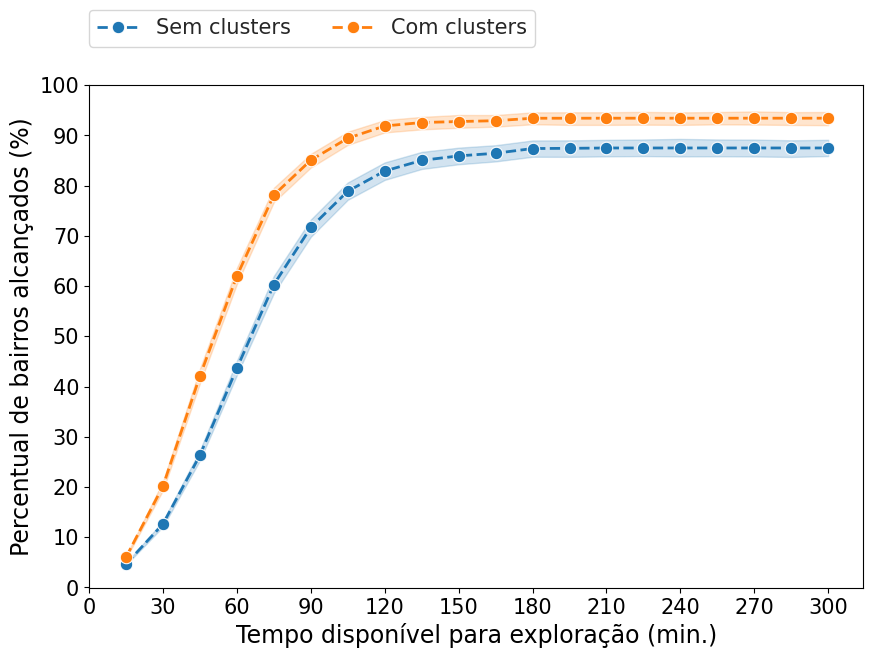

In [6]:
hue_order = list(set(cover_time.mag_name))
hue_order.sort(reverse = True)
fig, axes = plt.subplots(figsize = (8.9, 6.7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.lineplot(
    x = cover_time.time_window, y = cover_time.covered_pct, 
    palette = sns.color_palette("tab10", len(hue_order)),
    estimator = 'mean', errorbar = ('ci', 95), hue = cover_time.mag_name, hue_order = hue_order, 
    marker = 'o', markersize = 9, linestyle = "dashed", linewidth = 2, ax = axes
    #linestyle = "solid", linewidth = 2, ax = axes
)
g.set_xticks(range(0, 330, 30))
g.set_yticks(range(0, 110, 10))
g.legend(bbox_to_anchor = (0, 1.15), fontsize = 15, loc = "upper left", ncol = 3, borderaxespad = 0);
g.tick_params(labelsize = 15)
g.set_xlabel("Tempo disponível para exploração (min.)", fontsize = 17)
g.set_ylabel("Percentual de bairros alcançados (%)", fontsize = 17)
# Adjust spacing
plt.subplots_adjust(left=0.12, right=0.99, bottom=0.1, top=0.85, wspace=0.4)
plt.savefig('lineplot_cover_time_constrained.png', format='png', dpi=300);

In [12]:
cover_time = []
for pct in list(range(0, 105, 5)):
    threshold = int(pct * len(neighborhood_centroids) / 100)
    ct = neighborhood_time.query(
        f"reached_neighborhood <= {threshold} and end_time == 570"
    ).groupby(
        ['centroid_id', 'centroid_name', 'centroid_neighborhood', 'mag_name', 'mag_aspect', 'start_time', 'starting_node_idx']
    ).agg(
        tm_min = ('tm', 'min'),
        tm_max = ('tm', 'max'),
        n_max = ('reached_neighborhood', 'max'),
        covered_pct = ('pct', 'max')
    ).reset_index()
    ct.query(f"n_max == {threshold}", inplace = True)
    ct['dt'] = ct['tm_max'] - ct['tm_min']
    ct['target_pct'] = pct
    cover_time.append(ct)
cover_time = pd.concat(cover_time, ignore_index = True)    

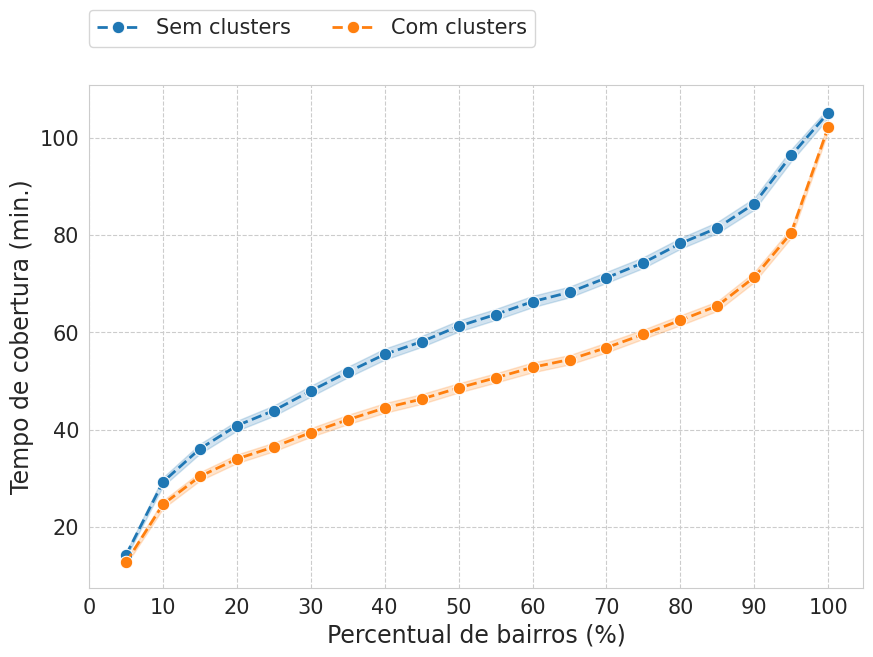

In [13]:
hue_order = list(set(cover_time.mag_name))
hue_order.sort(reverse = True)
fig, axes = plt.subplots(figsize = (8.9, 6.7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.lineplot(
    x = cover_time.target_pct, y = cover_time.dt, 
    palette = sns.color_palette("tab10", len(hue_order)),
    estimator = 'mean', errorbar = ('ci', 95), hue = cover_time.mag_name, hue_order = hue_order, 
    marker = 'o', markersize = 9, linestyle = "dashed", linewidth = 2, ax = axes
    #linestyle = "solid", linewidth = 2, ax = axes
)
g.set_xticks(range(0, 110, 10))
g.legend(bbox_to_anchor = (0, 1.15), fontsize = 15, loc = "upper left", ncol = 3, borderaxespad = 0);
g.tick_params(labelsize = 15)
g.set_xlabel("Percentual de bairros (%)", fontsize = 17)
g.set_ylabel("Tempo de cobertura (min.)", fontsize = 17)
# Adjust spacing
plt.subplots_adjust(left=0.12, right=0.99, bottom=0.1, top=0.85, wspace=0.4)
plt.savefig('lineplot_cover_time.png', format='png', dpi=300);

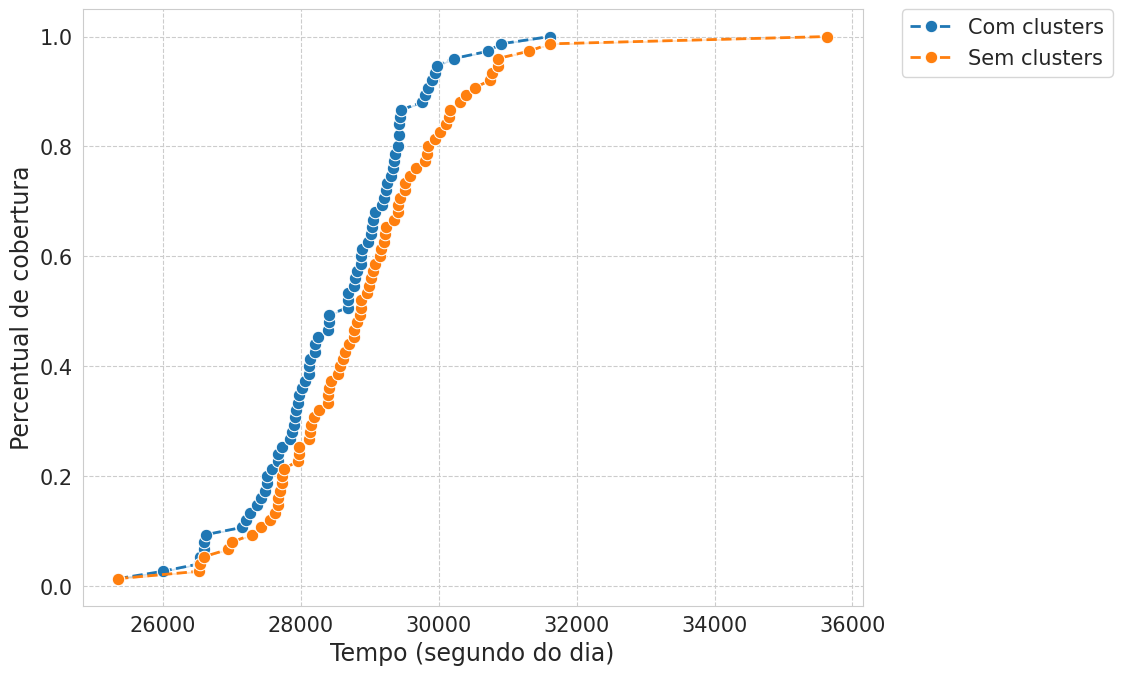

In [11]:
s = 420
centroid_name = 'Terminal CIC'
a = list(cover_time.query(f"centroid_name == '{centroid_name}' and start_time == {s} and mag_name == 'Sem clusters'").starting_node_idx)[0]
b = list(cover_time.query(f"centroid_name == '{centroid_name}' and start_time == {s} and mag_name == 'Com clusters'").starting_node_idx)[0]

plot = neighborhood_time.query("end_time == 720").merge(
    cover_time,
    how = 'inner'
).query(f"centroid_name == '{centroid_name}' and start_time == {s} and ((mag_name == 'Sem clusters' and starting_node_idx == {a}) or (mag_name == 'Com clusters' and starting_node_idx == {b})) and end_time == 720"
).copy()

hue_order = list(set(plot.mag_name))
hue_order.sort()
fig, axes = plt.subplots(figsize = (12, 6.7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.lineplot(
    x = plot.ts, y = plot.pct, 
    palette = sns.color_palette("tab10", len(hue_order)),
    estimator = 'mean', errorbar = ('ci', 95), hue = plot.mag_name, hue_order = hue_order, 
    marker = 'o', markersize = 9, linestyle = "dashed", linewidth = 2, ax = axes
)
#g.set_xticks(range(5, 24))
g.legend(bbox_to_anchor = (1.05, 1), fontsize = 15, loc = "upper left", ncol = 1, borderaxespad = 0);
g.tick_params(labelsize = 15)
g.set_xlabel("Tempo (segundo do dia)", fontsize = 17)
g.set_ylabel("Percentual de cobertura", fontsize = 17)
# Adjust spacing
plt.subplots_adjust(left=0.1, right=0.75, bottom=0.1, top=0.99, wspace=0.4)
plt.savefig('avg_conn.png', format='png', dpi=300);

In [13]:
cover_time.head()

,centroid_id,centroid_name,centroid_neighborhood,mag_name,mag_aspect,start_time,starting_node_idx,tm_min,tm_max,n_max,covered_pct,dt,target_pct
0,796,Estação PUC (Oficinas / Uberaba),GUABIROTUBA,Com clusters,dummy_id,420,1,420,427,3,0.04,7,5
1,796,Estação PUC (Oficinas / Uberaba),GUABIROTUBA,Com clusters,dummy_id,420,2,424,440,3,0.04,16,5
2,796,Estação PUC (Oficinas / Uberaba),GUABIROTUBA,Com clusters,dummy_id,420,3,420,430,3,0.04,10,5
3,796,Estação PUC (Oficinas / Uberaba),GUABIROTUBA,Com clusters,dummy_id,420,4,420,422,3,0.04,2,5
4,796,Estação PUC (Oficinas / Uberaba),GUABIROTUBA,Com clusters,dummy_id,420,5,421,430,3,0.04,9,5
